In [ ]:
import pandas as pd
import pickle
import glob
import matplotlib.pyplot as plt
from numpy import int64

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# csvファイルを読み込む
TRAIN_CSV_FILES = "csv/train/*.csv"

## 学習用
train_df = pd.DataFrame()
labels = []

csv_files = glob.glob(TRAIN_CSV_FILES)
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    data["label"] = len(labels)
    labels.append(csv_file.split("/")[-1].split(".")[0])
    train_df = pd.concat([train_df, data])

## テスト用
test_df = pd.read_csv("csv/test.csv")

In [3]:
# モデルの定義
clf_random_forest = RandomForestClassifier()
clf_xgboost = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
)
clf_lightgbm = LGBMClassifier(objective="multiclass", num_class=len(labels))

In [4]:
# 学習
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

clf_random_forest.fit(X_train, y_train)
clf_xgboost.fit(X_train, y_train)
clf_lightgbm.fit(X_train, y_train)

/Users/satooru/.pyenv/versions/3.10.12/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:47:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21674
[LightGBM] [Info] Number of data points in the train set: 1403, number of used features: 85
[LightGBM] [Info] Start training from score -1.360264
[LightGBM] [Info] Start training from score -1.360264
[LightGBM] [Info] Start training from score -1.360264
[LightGBM] [Info] Start training from score -1.468716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

LGBMClassifier(num_class=4, objective='multiclass')

In [5]:
# モデルの保存
with open("model/random_forest.pkl", "wb") as f:
    pickle.dump(clf_random_forest, f)

with open("model/xgboost.pkl", "wb") as f:
    pickle.dump(clf_xgboost, f)

with open("model/lightgbm.pkl", "wb") as f:
    pickle.dump(clf_lightgbm, f)

In [6]:
# テスト
X_test = test_df

y_pred_random_forest = clf_random_forest.predict(X_test)
y_pred_xgboost = clf_xgboost.predict(X_test)
y_pred_lightgbm = clf_lightgbm.predict(X_test)

In [7]:
# 正解ラベル
answer = [
    {
        "label": "other",
        "start": 0,
        "end": 1,
    },
    {
        "label": "1-walk",
        "start": 1,
        "end": 6,
    },
    {
        "label": "other",
        "start": 6,
        "end": 8,
    },
    {
        "label": "1-walk",
        "start": 8,
        "end": 38,
    },
    {
        "label": "other",
        "start": 38,
        "end": 39,
    },
    {
        "label": "2-quickrun",
        "start": 40,
        "end": 55,
    },
    {
        "label": "1-walk",
        "start": 55,
        "end": 75,
    },
    {
        "label": "other",
        "start": 75,
        "end": 81,
    },
    {
        "label": "5-mix",
        "start": 81,
        "end": 89,
    },
    {
        "label": "other",
        "start": 89,
        "end": 94,
    },
    {
        "label": "4-cut",
        "start": 94,
        "end": 110,
    },
    {
        "label": "other",
        "start": 110,
        "end": 114,
    },
    {
        "label": "5-mix",
        "start": 114,
        "end": 125,
    },
    {
        "label": "other",
        "start": 125,
        "end": 129,
    },
    {
        "label": "4-cut",
        "start": 129,
        "end": 140,
    },
    {
        "label": "other",
        "start": 140,
        "end": 143,
    },
    {
        "label": "1-walk",
        "start": 143,
        "end": 160,
    },
    {
        "label": "2-quickrun",
        "start": 160,
        "end": 190,
    },
    {
        "label": "1-walk",
        "start": 190,
        "end": 205,
    },
    {
        "label": "other",
        "start": 205,
        "end": 220,
    },
]

In [8]:
FRAM_RATE = 60


def color_map(index=None, label=None):
    colors = [
        "red",
        "blue",
        "yellow",
        "purple",
    ]

    if index is not None:
        return colors[index % len(labels)]
    if label is not None:
        # labels の index を取得
        try:
            i = labels.index(label)
            return colors[i % len(labels)]
        except ValueError:
            return "white"


def plot_pred(pred, title):
    plt.figure(figsize=(16, 2))
    plt.title(title)
    plt.xlim(0, len(pred) / FRAM_RATE + 1 / FRAM_RATE)
    plt.xlabel("time [s]")

    # 背景色を color_map に従って描画
    for i, p in enumerate(pred):
        time = i / FRAM_RATE
        plt.axvspan(
            time,
            time + 1 / FRAM_RATE,
            color=color_map(index=pred[i]),
            alpha=0.5,
            ymin=0.5,
            ymax=1,
        )

    # 正解ラベルをグラフに描画
    for a in answer:
        plt.axvspan(
            a["start"],
            a["end"],
            color=color_map(label=a["label"]),
            alpha=0.5,
            ymin=0,
            ymax=0.5,
        )

red    :5-mix
blue   :2-quickrun
yellow :4-cut
purple :1-walk


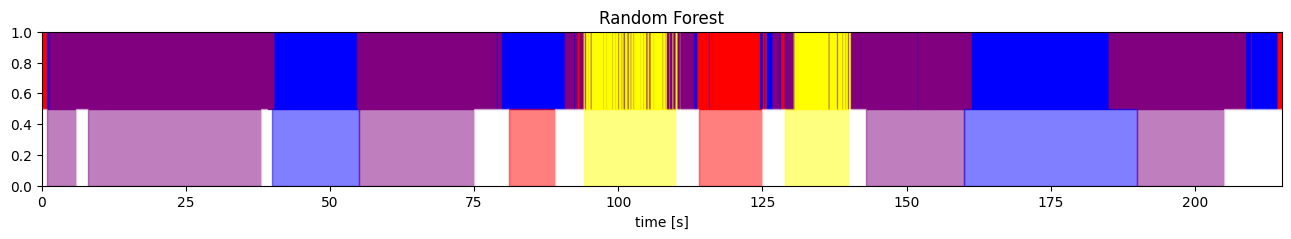

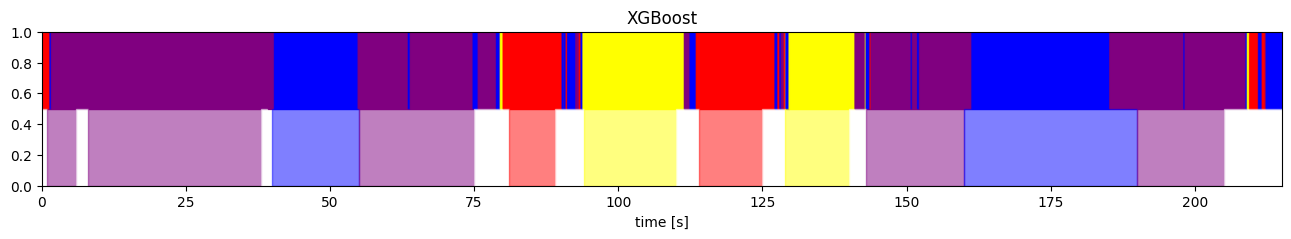

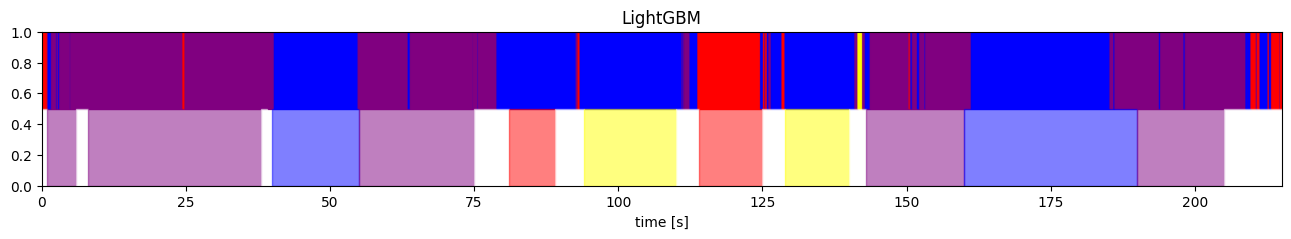

In [9]:
# グラフの描画
for v in map(lambda l: [l, color_map(label=l)], labels):
    print(f"{v[1]:7}:{v[0]}")

plot_pred(y_pred_random_forest, "Random Forest")
plot_pred(y_pred_xgboost, "XGBoost")
plot_pred(y_pred_lightgbm, "LightGBM")